<a href="https://colab.research.google.com/github/MuhammadHelmyOmar/Hadith/blob/main/bow_featuring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Data

In [ ]:
import pandas as pd

In [ ]:
data_url = 'https://raw.githubusercontent.com/KamelGaanoun/MHDetection/main/Corpus/trainFinal.csv'

data = pd.read_csv(data_url, index_col='Unnamed: 0')
print("CSV file loaded successfully!")
# Display the first few rows of the DataFrame
data.head()

CSV file loaded successfully!


,Matan,Degree
19036,لقد رأيتني وأنا ثلث الإسلام،‏.‏,0
17209,هريرة، أن أعرابيا، أتى النبي صلى الله عليه وس...,0
11245,عائشة، قالت كنت أفتل قلائد هدى رسول الله صلى ...,0
2827,قال النبي صلى الله عليه وسلم ‏ ‏ إني فرطكم على...,0
23616,عن النبي صلى الله عليه وسلم قال أقيموا الركوع ...,0


In [ ]:
# Filter data for each degree
data_degree_0 = data[data['Degree'] == 0]
data_degree_1 = data[data['Degree'] == 1]

# Sample 200 rows from each degree (if available)
# Use .sample(n, random_state) for reproducible sampling
sampled_degree_0 = data_degree_0.sample(n=min(1962, len(data_degree_0)), random_state=42)

# Concatenate the sampled dataframes
sampled_data = pd.concat([sampled_degree_0, data_degree_1])

# Display the value counts to verify the sampling
print("Value counts of the sampled data:")
display(sampled_data['Degree'].value_counts())

# Display the head of the sampled data
print("\nSampled data head:")
display(sampled_data.head())

Value counts of the sampled data:


,count
Degree,
0,1962
1,1962



Sampled data head:


,Matan,Degree
13645,أنها استعارت من أسماء قلادة فهلكت فأرسل النبي ...,0
16561,يقول كان رسول الله صلى الله عليه وسلم يأتي قبا...,0
13787,هريرة، أن رسول الله صلى الله عليه وسلم قال قلب...,0
4475,أبيه، أن النبي صلى الله عليه وسلم قال لا تزال ...,0
16463,القاسم صلى الله عليه وسلم تسموا باسمي ولا تكنو...,0


In [ ]:
labels = sampled_data['Degree'].values
labels.shape

(3924,)

In [ ]:
# # # Save the sampled data to a CSV file
# sampled_data[sampled_data['Degree'] == 1].to_csv('unauthentic_hadith.csv', index=False)
# print("Sampled data saved to 'unauthentic_hadith.csv'")

# Preprocessing

In [ ]:
import re
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
arabic_stopwords = set(nltk.corpus.stopwords.words("arabic"))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
sampled_data['text_length'] = sampled_data['Matan'].str.len()
sampled_data['stopwords_count'] = sampled_data['Matan'].apply(lambda hadith: len([word for word in hadith.split() if word in arabic_stopwords]))
sampled_data = sampled_data.sort_values(by='text_length',ascending=[0])
display(sampled_data.head())
display(sampled_data.tail())

,Matan,Degree,text_length,stopwords_count
1427,لما أسري بي إلى السماء رأيت فيها أعاجيب من ع...,1,29527,1629
4106,أن جبريل عليه السلام أتى النبي صلى الله عليه...,1,9507,440
3738,زيارة إبليس اللعين للنبي صلى الله عليه وسلم...,1,9363,474
10718,أنس بن مالك رضي الله عنه قال: ((جاء جبريل إ...,1,8711,438
22047,((روي عن النبي صلى الله عليه وآله وسلم أنه ق...,1,7504,471


,Matan,Degree,text_length,stopwords_count
18259,اسمح يسمح لك,1,13,1
9934,لكل قادم نصيب,1,13,0
615,التكبير جزم,1,12,0
16216,الزرقة يمن,1,12,0
9591,الزرقة يمن,1,10,0


In [ ]:
def remove_diacritics(text):
  """
  Removes Arabic diacritics from a given text.

  Args:
    text: The input Arabic text with diacritics.

  Returns:
    The text with diacritics removed.
  """
  text = text.replace(u"\u064B", "")  # fatHatayn
  text = text.replace(u"\u064C", "")  # Dammatayn
  text = text.replace(u"\u064D", "")  # kasratayn
  text = text.replace(u"\u064E", "")  # fatHa
  text = text.replace(u"\u064F", "")  # Damma
  text = text.replace(u"\u0650", "")  # kasra
  text = text.replace(u"\u0651", "")  # shaddah
  text = text.replace(u"\u0652", "")  # sukuun
  text = text.replace(u"\u0670", "`")  # dagger 'alif
  return text

# def remove_isnad(text):
#   """
#   Removes the isnad (chain of narrators) from a Hadith text using regex.

#   Args:
#     text: The input Hadith text.

#   Returns:
#     The text with the isnad removed.
#   """
#   # Use keyrings
#   text = re.sub(r".*(قال\s*|عن\s*)((رسول\s*الله\s*)|الرسول\s*|النبي\s*)((صلى\s*الله\s*عليه\s*وسلم\s*)|ص\s*|(عليه\s*الصلاة\s*والسلام\s*))*", ' ', text)
#   text = re.sub(r".*(قال\s*|عنه\s*)((صلى\s*الله\s*عليه\s*وسلم\s*)|ص\s*|(عليه\s*الصلاة\s*والسلام\s*))", ' ', text)
#   text = re.sub(r".*(عنه\s*|عن\s*)*((رسول\s*الله\s*)|الرسول\s*|النبي\s*)*((صلى\s*الله\s*عليه\s*وسلم\s*)|ص\s*|(عليه\s*الصلاة\s*والسلام\s*))(أنه\s*)*(قال\s*|يقول\s*)", ' ', text)
#   return text

def remove_interjections(text):
  text = re.sub(r"صلى\s*الله\s*عليه\s*(وسلم\s*|وآله\s*)*", ' ', text)
  text = re.sub(r"رضي\s*الله\s*عنه\s*", ' ', text)
  text = re.sub(r"عليه\s*(السلام\s*|((أفضل\s*)*الصلاة\s*والسلام\s*))", ' ', text)
  # return " ".join([w for w in text.split() if w not in ["قال", "فقال", "الله", "رسول", "الرسول", "النبي", "نبي", "وقال"]])
  return text

def remove_stopwords(text):
  """
  Removes Arabic stopwords from a given text.

  Args:
    text: The input Arabic text.

  Returns:
    The text with stopwords removed.
  """
  return " ".join([w for w in text.split() if w not in arabic_stopwords])

In [ ]:
sampled_data['Matan'] = sampled_data['Matan'].apply(lambda hadith: remove_diacritics(hadith))
# sampled_data['Matan'] = sampled_data['Matan'].apply(lambda hadith: remove_isnad(hadith))
sampled_data['Matan'] = sampled_data['Matan'].apply(lambda hadith: remove_interjections(hadith))
sampled_data['Matan'] = sampled_data['Matan'].apply(lambda hadith: remove_stopwords(hadith))

sampled_data['text_length'] = sampled_data['Matan'].str.len()
sampled_data['stopwords_count'] = sampled_data['Matan'].apply(lambda hadith: len([word for word in hadith.split() if word in arabic_stopwords]))
sampled_data = sampled_data.sort_values(by='text_length',ascending=[0])
display(sampled_data.head())
display(sampled_data.tail())

,Matan,Degree,text_length,stopwords_count
1427,أسري السماء رأيت أعاجيب عباد الله وخلقه، رأيت ...,1,23605,0
4106,"جبريل أتى النبي فقال: محمد, السلام يقرئك السلا...",1,7731,0
3738,زيارة إبليس اللعين للنبي بيت رجل الأنصار: بن ج...,1,7589,0
10718,أنس بن مالك قال: ((جاء جبريل النبي ساعة يأتيه ...,1,6617,0
22047,((روي النبي أنه قال: قرأ الدعاء عمره مرة واحدة...,1,5579,0


,Matan,Degree,text_length,stopwords_count
23926,: يزل سرور,1,10,0
9591,الزرقة يمن,1,10,0
347,أكل مغفور,1,9,0
18259,اسمح يسمح,1,9,0
9522,تقع أحبته,1,9,0


In [ ]:
len(sampled_data[sampled_data['text_length']==0])

0

# Exploratory Text Analysis

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

## Top N words

In [ ]:
# Separating Degrees

top_n = 20

# Filter data by degree
data_degree_0_text = sampled_data[sampled_data['Degree'] == 0]['Matan']
data_degree_1_text = sampled_data[sampled_data['Degree'] == 1]['Matan']

# Create CountVectorizer objects for each degree
vectorizer_degree_0 = CountVectorizer(stop_words=list(arabic_stopwords), min_df=1, max_df=200)
vectorizer_degree_1 = CountVectorizer(stop_words=list(arabic_stopwords), min_df=1, max_df=200)

# Transform the data for each degree
bow_degree_0 = vectorizer_degree_0.fit_transform(data_degree_0_text)
bow_degree_1 = vectorizer_degree_1.fit_transform(data_degree_1_text)

# Get feature names (words) and counts for each degree
words_degree_0 = vectorizer_degree_0.get_feature_names_out()
counts_degree_0 = bow_degree_0.sum(axis=0).A1
word_counts_0 = dict(zip(words_degree_0, counts_degree_0))
word_counts_0 = dict(sorted(word_counts_0.items(), key=lambda item: item[1], reverse=True))

words_degree_1 = vectorizer_degree_1.get_feature_names_out()
counts_degree_1 = bow_degree_1.sum(axis=0).A1
word_counts_1 = dict(zip(words_degree_1, counts_degree_1))
word_counts_1 = dict(sorted(word_counts_1.items(), key=lambda item: item[1], reverse=True))


print(f"Top {top_n} most frequent words for Degree 0:")
display(pd.DataFrame(list(word_counts_0.items())[:top_n], columns=['Word', 'Count']))

print(f"\nTop {top_n} most frequent words for Degree 1:")
display(pd.DataFrame(list(word_counts_1.items())[:top_n], columns=['Word', 'Count']))

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['آمين', 'أب', 'أخ', 'أفعل', 'أفعله', 'ؤلاء', 'إل', 'إم', 'ات', 'اتان', 'ارتد', 'ان', 'انفك', 'برح', 'تان', 'تبد', 'تحو', 'تعل', 'حد', 'حم', 'حي', 'خب', 'ذار', 'سيما', 'صه', 'ظل', 'ظن', 'عد', 'قط', 'مر', 'مكان', 'مكانكن', 'نب', 'هات', 'هب', 'واها', 'وراء'] not in stop_words.
  warnings.warn(


Top 20 most frequent words for Degree 0:


,Word,Count
0,ابن,246
1,أبي,239
2,عبد,228
3,قالت,197
4,الناس,181
5,رجل,181
6,فلما,174
7,وقال,174
8,عمر,172
9,يوم,166



Top 20 most frequent words for Degree 1:


,Word,Count
0,النبي,288
1,علي,277
2,محمد,256
3,تعالى,227
4,جبريل,216
5,بن,213
6,القيامة,183
7,الناس,178
8,النار,168
9,بكر,161


## Word Cloud

In [ ]:
!pip install -qU arabic-reshaper python-bidi ar_wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 6.3 MB/s eta 0:00:00


In [ ]:
from ar_wordcloud import ArabicWordCloud
import matplotlib.pyplot as plt
from bidi.algorithm import get_display
import arabic_reshaper

downloading and unzipping arabic font: /usr/local/lib/python3.12/dist-packages/ar_wordcloud/fonts/NotoNaskhArabic-unhinted.zip .. 
downloading and unzipping arabic font: /usr/local/lib/python3.12/dist-packages/ar_wordcloud/fonts/NotoSansArabic-unhinted.zip .. 
downloading and unzipping arabic font: /usr/local/lib/python3.12/dist-packages/ar_wordcloud/fonts/NotoKufiArabic-unhinted.zip .. 


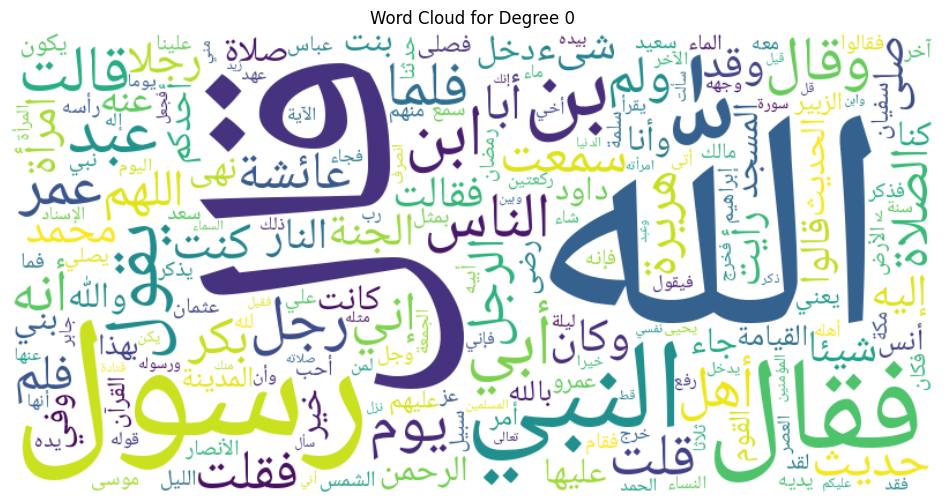

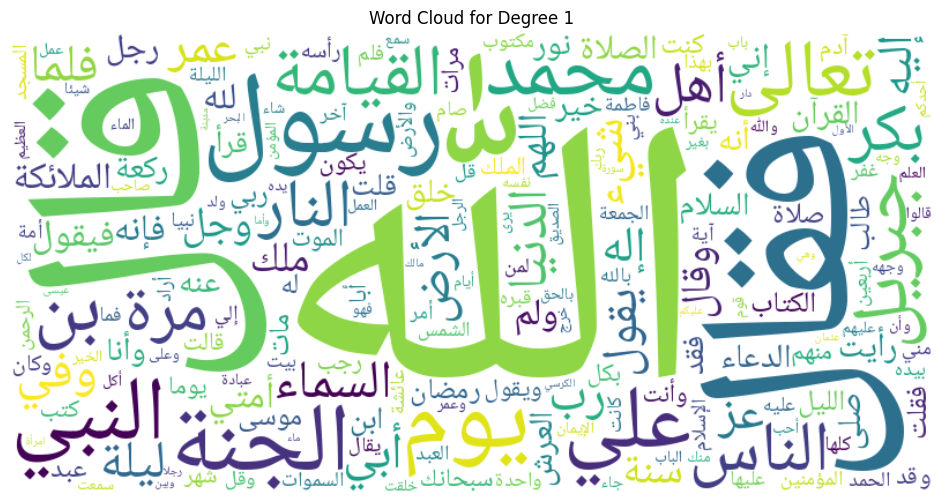

In [ ]:
# Combine all text for each degree
text_degree_0 = " ".join(data_degree_0_text)
text_degree_1 = " ".join(data_degree_1_text)

# Reshape Arabic text for correct display in word cloud
reshaped_text_0 = arabic_reshaper.reshape(text_degree_0)
bidi_text_0 = get_display(reshaped_text_0)

reshaped_text_1 = arabic_reshaper.reshape(text_degree_1)
bidi_text_1 = get_display(reshaped_text_1)

# Generate word cloud for Degree 0
awc_0 = ArabicWordCloud(background_color="white", width=800, height=400, stopwords=list(arabic_stopwords), collocations=False)
wc_0 = awc_0.from_text(bidi_text_0)

# Generate word cloud for Degree 1
awc_1 = ArabicWordCloud(background_color="white", width=800, height=400, stopwords=list(arabic_stopwords), collocations=False)
wc_1 = awc_1.from_text(bidi_text_1)

# Display the word clouds
plt.figure(figsize=(12, 6))
plt.imshow(wc_0, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Degree 0')

plt.figure(figsize=(12, 6))
plt.imshow(wc_1, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Degree 1')

# plt.tight_layout()
plt.show()

## Comparing lengths

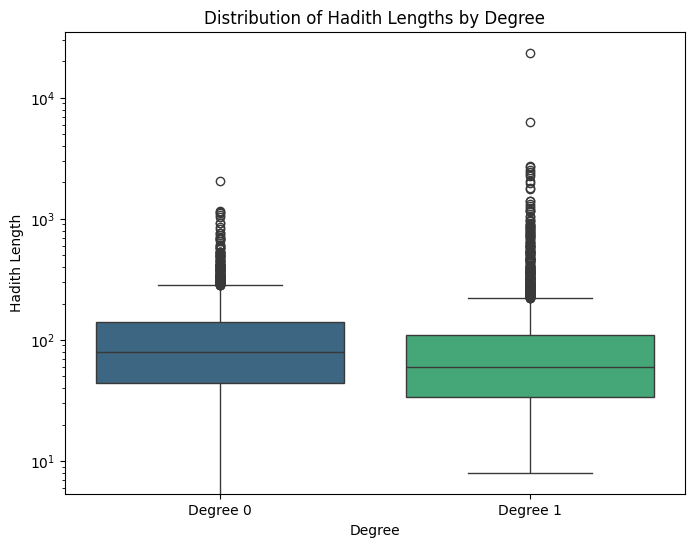

In [ ]:
# Create box plots for Hadith lengths by degree
plt.figure(figsize=(8, 6))
sns.boxplot(x='Degree', y='text_length', data=sampled_data, hue='Degree', palette='viridis', legend=False)
plt.title('Distribution of Hadith Lengths by Degree')
plt.xlabel('Degree')
plt.ylabel('Hadith Length')
plt.xticks([0, 1], ['Degree 0', 'Degree 1'])
plt.yscale('log') # Scaled the y-axis logarithmically
plt.show()

In [ ]:
# Calculate percentiles for text length by degree
percentiles = sampled_data.groupby('Degree')['text_length'].quantile([0.25, 0.5, 0.75])

print("Percentiles of Hadith Length by Degree:")
display(percentiles)

Percentiles of Hadith Length by Degree:


Degree      
0       0.25     44.25
        0.50     80.00
        0.75    140.00
1       0.25     34.00
        0.50     60.00
        0.75    109.00
Name: text_length, dtype: float64

In [ ]:
# Calculate IQR for each degree
Q1 = sampled_data.groupby('Degree')['text_length'].quantile(0.25)
Q3 = sampled_data.groupby('Degree')['text_length'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
upper_bound = Q3 + 1.5 * IQR

print("\nUpper bounds for outliers:")
display(upper_bound)

# Identify outliers for each degree
outliers_degree_0 = sampled_data[(sampled_data['Degree'] == 0) &
                                (sampled_data['text_length'] > upper_bound[0])]

outliers_degree_1 = sampled_data[(sampled_data['Degree'] == 1) &
                                (sampled_data['text_length'] > upper_bound[1])]


# Print the number of outliers
print(f"Number of outliers for Degree 0 above upper bound: {len(outliers_degree_0)}")
print(f"Number of outliers for Degree 1 above upper bound: {len(outliers_degree_1)}")


Upper bounds for outliers:


,text_length
Degree,
0,283.625
1,221.500


Number of outliers for Degree 0 above upper bound: 133
Number of outliers for Degree 1 above upper bound: 214


# Classifiers

In [ ]:
from sklearn import metrics
import numpy as np

## Split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Create a CountVectorizer Object
vectorizer = CountVectorizer(stop_words=list(arabic_stopwords), min_df=1)

# Fit and transform the corpus
bow = vectorizer.fit_transform(sampled_data['Matan'])

# Print the length of the generated vocabulary
print("Vocabulary Size:", len(vectorizer.get_feature_names_out()))

# Print the Bag-of-Words matrix
print("BoW Representation:")
print(bow.toarray())
print(bow.shape)

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['آمين', 'أب', 'أخ', 'أفعل', 'أفعله', 'ؤلاء', 'إل', 'إم', 'ات', 'اتان', 'ارتد', 'ان', 'انفك', 'برح', 'تان', 'تبد', 'تحو', 'تعل', 'حد', 'حم', 'حي', 'خب', 'ذار', 'سيما', 'صه', 'ظل', 'ظن', 'عد', 'قط', 'مر', 'مكان', 'مكانكن', 'نب', 'هات', 'هب', 'واها', 'وراء'] not in stop_words.
  warnings.warn(


Vocabulary Size: 24375
BoW Representation:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(3924, 24375)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(bow, labels, test_size=0.2,random_state=109)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3139, 24375), (785, 24375), (3139,), (785,))

## SVC

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
clf = LinearSVC(random_state=109)
clf.fit(X_train, y_train)

LinearSVC(random_state=109)

### Evaluation

In [ ]:
y_pred = clf.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test, y_pred))

Accuracy: 0.8636942675159236
Precision: 0.8008752735229759
Recall: 0.9581151832460733
F1 Score: 0.8724672228843862


In [ ]:
coefficients = list(clf.coef_[0])
words = list(vectorizer.get_feature_names_out())
maximas = {}
minimas = {}

for i in range(100):
  max_value = max(coefficients)
  min_value = min(coefficients)

  mx = coefficients.index(max_value)
  maximas[words[mx]] = max_value
  coefficients.pop(mx)
  words.pop(mx)

  mn = coefficients.index(min_value)
  minimas[words[mn]] = min_value
  coefficients.pop(mn)

In [ ]:
minimas.keys()

dict_keys(['بالشهوة', 'سأقضي', 'زهده', 'جاءهم', 'سعدا', 'الصبراء', 'وليدا', 'وهزم', 'وأموالهم', 'رقابهم', 'الخدري', 'وكأن', 'خشيت', 'عبدالنبي', 'وقابس', 'ففهمني', 'وأمهات', 'أقوام', 'كالكوكب', 'بعرق', 'قولي', 'يردفها', 'مقلوبأ', 'خراج', 'اللقمة', 'وعرف', 'الآجل', 'ويؤتي', 'لمعلمه', 'رمل', 'المعنى', 'حيى', 'أتي', 'الجنود', 'أخبركم', 'بأنك', 'وإما', 'وموجود', 'لمحرم', 'كلامي', 'وإرعا', 'الهيم', 'بنفسين', 'إنكم', 'خطيئتي', 'وغيره', 'وأمراؤهم', 'وفتح', 'الميتة', 'أعطاكموها', 'وطوله', 'سلوا', 'أمر', 'علام', 'أدخلها', 'البرودة', 'شاطئاه', 'يخففوا', 'الدرجتين', 'ربكم', 'الوحي', 'فلاكهن', 'يقرأ', 'أخبرني', 'وعيله', 'يحترق', 'بشأنهم', 'ماؤها', 'المرجئة', 'إله', 'ميثاق', 'عاصيا', 'حزنه', 'ميراث', 'الكبرى', 'السائب', 'الطائفين', 'الموضوع', 'الأعرابي', 'وأطراف', 'فغزا', 'خلقت', 'وقاتل', 'استعارت', 'أيمان', 'رابها', 'وأولاده', 'بتور', 'أعقابنا', 'ورحمتي', 'أموالا', 'نبىء', 'نعمي', 'وليبلغ', 'قلبة', 'سراويل', 'يتم', 'السور', 'فيشهدون', 'المحصنات'])

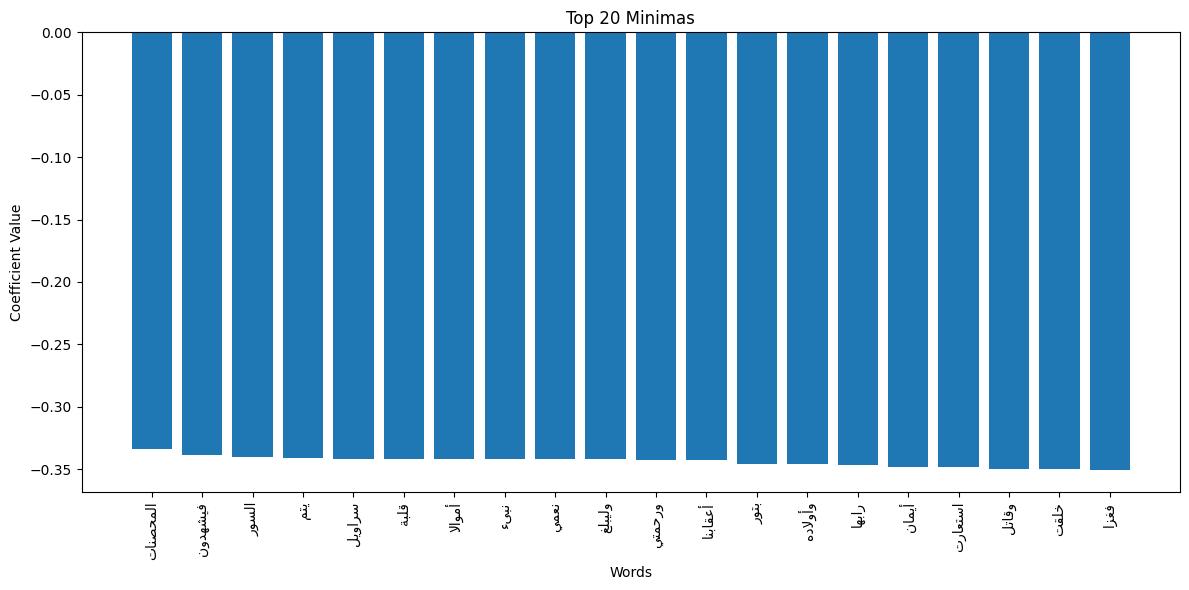

In [ ]:
# Plot the coefficients for minimas
minimas = dict(sorted(minimas.items(), key=lambda item: abs(item[1]), reverse=False))

top_20_words = [get_display(arabic_reshaper.reshape(word)) for word in list(minimas.keys())[:20]]

plt.figure(figsize=(12, 6))
plt.bar(top_20_words, list(minimas.values())[:20])
plt.xticks(rotation=90)
plt.title('Top 20 Minimas')
plt.xlabel('Words')
plt.ylabel('Coefficient Value')
plt.tight_layout()
plt.show()

In [ ]:
maximas.keys()

dict_keys(['جاؤوا', 'وليسا', 'زهد', 'إثر', 'خفت', 'يمسك', 'أذنيه', 'شهر', 'أوف', 'وقلوبهم', 'مؤونته', 'نابتا', 'وتد', 'الفارسية', 'بكرا', 'مقالتي', 'فليتحرها', 'فضحك', 'أغسل', 'القد', 'أدومه', 'بأمره', 'الوبر', 'ألعب', 'سليمان', 'عوانة', 'يفخر', 'نحب', 'أنفسهن', 'تدع', 'ثبطة', 'بشهادة', 'القديم', 'العاقب', 'بنيك', 'جبر', 'يحصى', 'تمامه', 'القرنين', 'عبيدي', 'بمخلص', 'لأخي', 'وأبطأ', 'قصعتهم', 'فرضتان', 'أولته', 'سألته', 'جهر', 'للمؤمنين', 'سأنظر', 'عذت', 'قلنا', 'يحلفوا', 'استسقى', 'وللنبي', 'كأسنمة', 'الأذرمي', 'كهيعص', 'وهيب', 'يتلو', 'ننتهب', 'أكفه', 'نشيطا', 'الأشير', 'بخبر', 'مداركا', 'مرجئيا', 'بموئل', 'الخميصة', 'فأصابني', 'شجر', 'سئلوا', 'النبأ', 'فدعوته', 'رءوسها', 'غنية', 'يؤم', 'سألوك', 'يصبره', 'فتسلك', 'يسعى', 'الصواعق', 'فساعدتها', 'نفعله', 'ثعبان', 'هجع', 'نسبي', 'المرزوق', 'ملائكتك', 'الصحف', 'حديثا', 'رمي', 'فرحتين', 'تطوع', 'المذنبين', 'والجبابرة', 'ونم', 'ثكلت', 'حليم', 'حلت'])

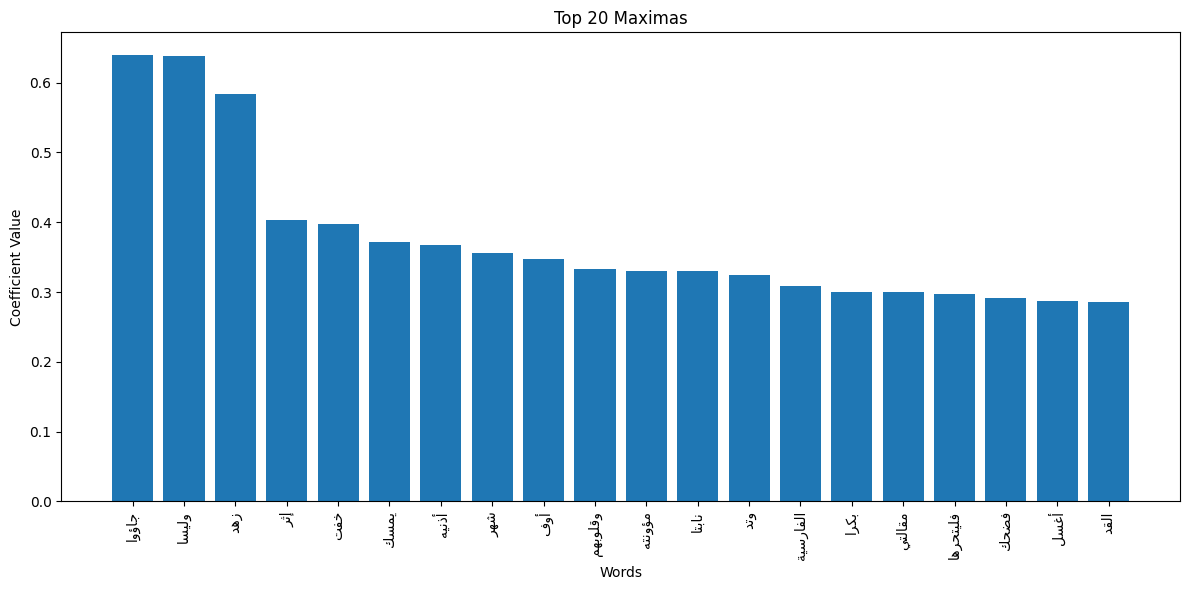

In [ ]:
# Plot the coefficients for maximas
maximas = dict(sorted(maximas.items(), key=lambda item: abs(item[1]), reverse=True))

top_20_words = [get_display(arabic_reshaper.reshape(word)) for word in list(maximas.keys())[:20]]

plt.figure(figsize=(12, 6))
plt.bar(top_20_words, list(maximas.values())[:20])
plt.xticks(rotation=90)
plt.title('Top 20 Maximas')
plt.xlabel('Words')
plt.ylabel('Coefficient Value')
plt.tight_layout()
plt.show()

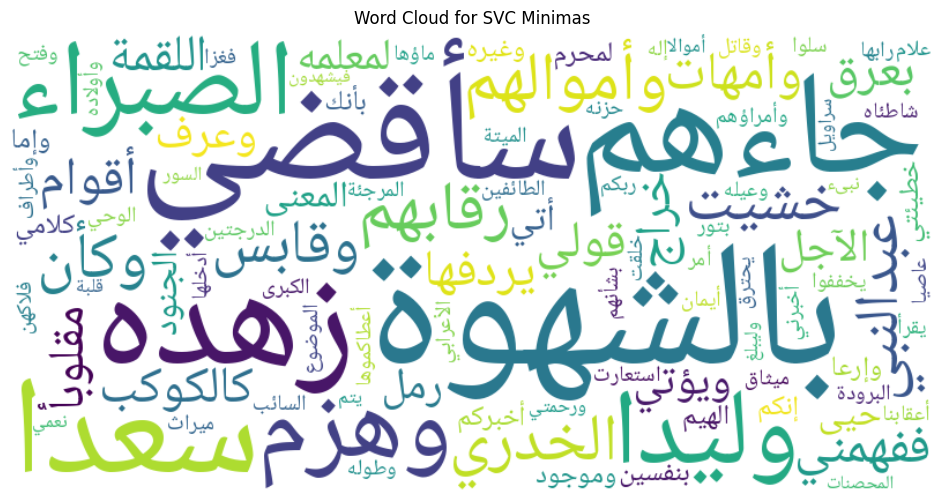

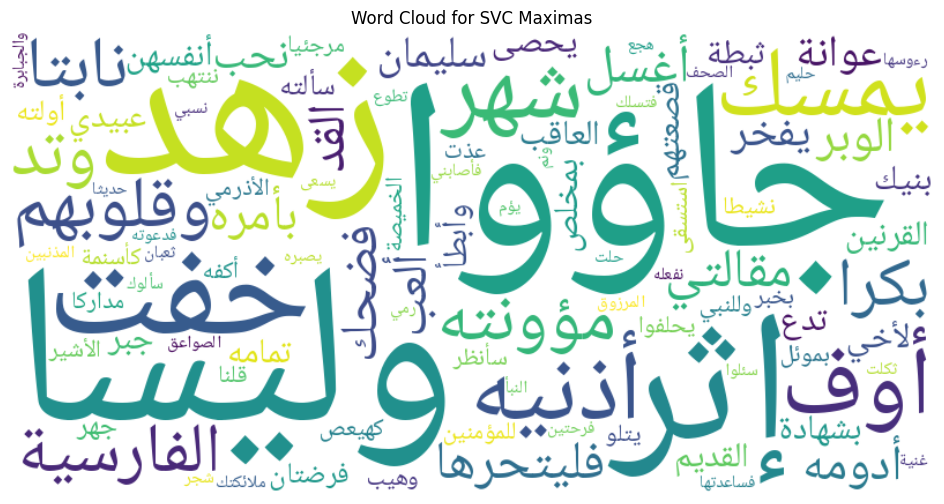

In [ ]:
# Generate word cloud for SVC Minimas
awc_svc_minimas = ArabicWordCloud(background_color="white", width=800, height=400, collocations=False)
# Need to use absolute values for word cloud size, but keep the negative sign in mind for interpretation
minimas_abs = {word: abs(weight) for word, weight in minimas.items()}
wc_svc_minimas = awc_svc_minimas.generate_from_frequencies(minimas_abs)

plt.figure(figsize=(12, 6))
plt.imshow(wc_svc_minimas, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for SVC Minimas')
plt.show()

# Generate word cloud for SVC Maximas
awc_svc_maximas = ArabicWordCloud(background_color="white", width=800, height=400, collocations=False)
wc_svc_maximas = awc_svc_maximas.generate_from_frequencies(maximas)

plt.figure(figsize=(12, 6))
plt.imshow(wc_svc_maximas, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for SVC Maximas')
plt.show()

## Lasso Regression Model

In [ ]:
from sklearn.linear_model import Lasso


Fitting Lasso model with alpha = 0.005


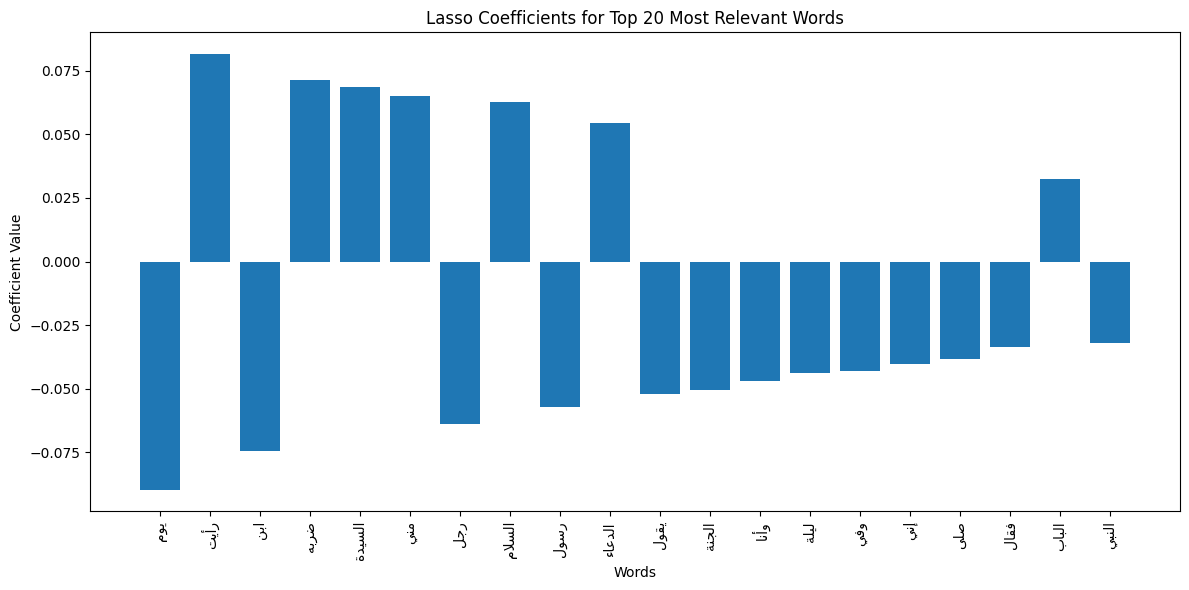


Fitting Lasso model with alpha = 0.001


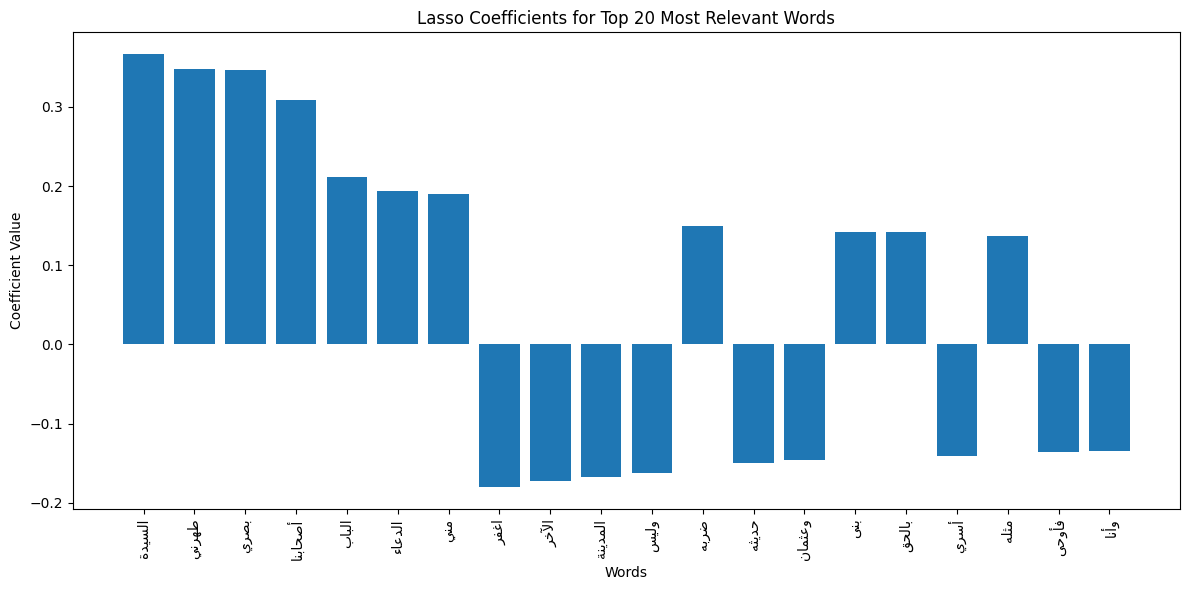

In [ ]:
# Try different alpha values and observe the coefficients
alpha_values = [0.005, 0.001]
words = vectorizer.get_feature_names_out()

for alpha in alpha_values:
    print(f"\nFitting Lasso model with alpha = {alpha}")
    lasso_model = Lasso(alpha=alpha, random_state=109)
    lasso_model.fit(X_train, y_train)
    lasso_coefficients = lasso_model.coef_
    word_coefficients = dict(zip(words, lasso_coefficients))
    word_coefficients = dict(sorted(word_coefficients.items(), key=lambda item: abs(item[1]), reverse=True))

    # Plot the coefficients
    top_20_words = [get_display(arabic_reshaper.reshape(word)) for word in list(word_coefficients.keys())[:20]]

    plt.figure(figsize=(12, 6))
    plt.bar(top_20_words, list(word_coefficients.values())[:20])
    plt.xticks(rotation=90)
    plt.title('Lasso Coefficients for Top 20 Most Relevant Words')
    plt.xlabel('Words')
    plt.ylabel('Coefficient Value')
    plt.tight_layout()
    plt.show()

### Evaluation

In [ ]:
y_pred_lasso = (lasso_model.predict(X_test) > 0.5).astype(int)

# Evaluate the performance of the Lasso model as a classifier
accuracy = metrics.accuracy_score(y_test, y_pred_lasso)
precision = metrics.precision_score(y_test, y_pred_lasso)
recall = metrics.recall_score(y_test, y_pred_lasso)
f1 = metrics.f1_score(y_test, y_pred_lasso)

print(f"Lasso Model Performance (as a classifier) with alpha={lasso_model.alpha}:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Lasso Model Performance (as a classifier) with alpha=0.001:
Accuracy: 0.7669
Precision: 0.6832
Recall: 0.9712
F1 Score: 0.8022


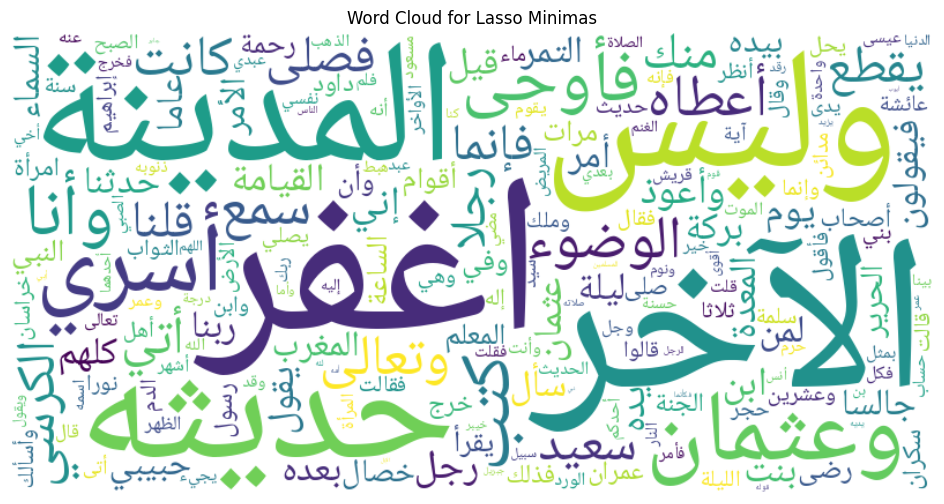

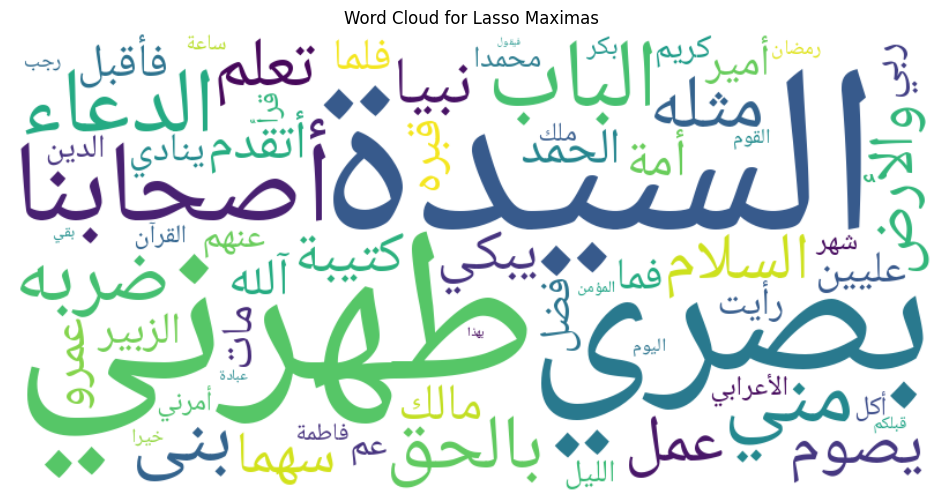

In [ ]:
# Get Lasso coefficients from the last fitted model
lasso_coefficients = dict(zip(vectorizer.get_feature_names_out(), lasso_model.coef_))

# Separate Lasso minimas and maximas
lasso_minimas = {word: weight for word, weight in lasso_coefficients.items() if weight < 0}
lasso_maximas = {word: weight for word, weight in lasso_coefficients.items() if weight > 0}

# Sort Lasso minimas and maximas by absolute weight
lasso_minimas = dict(sorted(lasso_minimas.items(), key=lambda item: abs(item[1]), reverse=True))
lasso_maximas = dict(sorted(lasso_maximas.items(), key=lambda item: abs(item[1]), reverse=True))

# Generate word cloud for Lasso Minimas
awc_lasso_minimas = ArabicWordCloud(background_color="white", width=800, height=400, collocations=False)
lasso_minimas_abs = {word: abs(weight) for word, weight in lasso_minimas.items()}
wc_lasso_minimas = awc_lasso_minimas.generate_from_frequencies(lasso_minimas_abs)

plt.figure(figsize=(12, 6))
plt.imshow(wc_lasso_minimas, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Lasso Minimas')
plt.show()

# Generate word cloud for Lasso Maximas
awc_lasso_maximas = ArabicWordCloud(background_color="white", width=800, height=400, collocations=False)
wc_lasso_maximas = awc_lasso_maximas.generate_from_frequencies(lasso_maximas)

plt.figure(figsize=(12, 6))
plt.imshow(wc_lasso_maximas, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Lasso Maximas')
plt.show()

# Next